In [0]:
# import package
from pyspark.sql import SQLContext
from pyspark.sql import Window 
from pyspark.sql import functions as func
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType 
from pyspark.sql import DataFrame
from pyspark.sql.functions import col



from pyspark.ml import Pipeline

from pyspark.ml.linalg import Vectors 
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from pyspark.sql import *

from math import log,ceil

import seaborn as sns


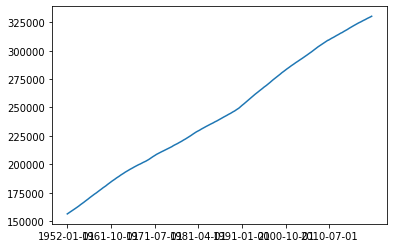

In [0]:
# Create dataframe 
sqlContext = SQLContext(sc)
df = sqlContext.sql("select date, value from pop_use")

# Exploratory Data Analysis(display the time series data)
#df.show()
plt.plot(df.toPandas()['date'], df.toPandas()['value'].astype(float))
x_ticks = (df.toPandas()['date'].index)
plt.xticks(x_ticks)
plt.locator_params(axis = 'x', nbins = 7)



In [0]:
# Generate seasonality features 
df1 = df.withColumn('year',func.year(func.to_timestamp('date','yyyy-MM-dd')))\
.withColumn("quarter",func.quarter(func.to_timestamp('date','yyyy-MM-dd')))\
.withColumn("month",func.month(func.to_timestamp('date','yyyy-MM-dd')))\
.withColumn("day_of_the_week", func.dayofweek(func.to_timestamp('date','yyyy-MM-dd')))

In [0]:
# Create partition window 
partitionWindow = Window.partitionBy().orderBy('date')

# Change prediction horizon by changing lag step of lag1 
prediction_horizon = 1


# Create lag features, moving averages, differencing features 
df2 = df1.withColumn("season_num", func.lag("quarter",2).over(partitionWindow))\
.na.fill(4)\
.withColumn("season_str", func.when(func.col("season_num")==1,"spring").when(func.col("season_num")==2,"summer").when(func.col("season_num")==3,"fall").otherwise("winter"))\
.withColumn("lag1", func.lag("value", prediction_horizon).over(partitionWindow))\
.withColumn("lag2", func.lag("lag1", 1).over(partitionWindow))\
.withColumn("lag3", func.lag("lag2", 1).over(partitionWindow))\
.withColumn("lag4", func.lag("lag3",1).over(partitionWindow))\
.withColumn("lag5", func.lag("lag4",1).over(partitionWindow))\
.withColumn("lag6", func.lag("lag5",1).over(partitionWindow))\
.withColumn("lag7", func.lag("lag6", 1).over(partitionWindow))\
.withColumn("lag8", func.lag("lag7", 1).over(partitionWindow))\
.withColumn("lag9", func.lag("lag8", 1).over(partitionWindow))\
.withColumn("lag10", func.lag("lag9", 1).over(partitionWindow))\
.withColumn("lag11", func.lag("lag10", 1).over(partitionWindow))\
.withColumn("lag12", func.lag("lag11", 1).over(partitionWindow))\
.withColumn("1st_order_difference", func.col("value")-func.col("lag1"))\
.withColumn("moving_avg_1", (func.col("lag1")+func.col("lag2")+func.col("lag3"))/3)\
.withColumn("moving_avg_2", (func.col("lag4")+func.col("lag5")+func.col("lag6"))/3)\
.withColumn("moving_avg_3", (func.col("lag7")+func.col("lag8")+func.col("lag9"))/3)\
.withColumn("moving_avg_4", (func.col("lag10")+func.col("lag11")+func.col("lag12"))/3)\
.drop("lag2","lag3","lag4","lag5","lag6","lag7","lag8","lag9","lag10","lag11","season_num")#,"previous_1st_order_difference","value_t-1")

In [0]:
# apply stringindexer on season string 
stringIndexer = StringIndexer(inputCol=('season_str'),
                             outputCol=('season'))

df3 = stringIndexer.fit(df2).transform(df2).drop('season_str')

In [0]:
# drop rows existing null values and rearrange columns 
df4 = df3.na.drop()\
.select(func.col("date"),func.col("year"),func.col("quarter"),func.col("season"),func.col("month"),func.col("day_of_the_week"),func.col("lag1"),func.col("lag12"),func.col("1st_order_difference"),func.col("moving_avg_1"),func.col("moving_avg_2"),func.col("moving_avg_3"),func.col("moving_avg_4"),func.col("value"))\
.withColumn("row", func.row_number().over(partitionWindow))

In [0]:
df4.count()

Out[162]: 804

In [0]:
## change the "lag1" and "lag12" variable type to integer
df4 = df4.withColumn("lag1",df4["lag1"].cast(IntegerType()))
df4 = df4.withColumn("lag12",df4["lag12"].cast(IntegerType()))

In [0]:
## produce feature and label
assembler = VectorAssembler()\
.setInputCols(("year","quarter","season","month","day_of_the_week","lag1","lag12","moving_avg_1","moving_avg_2","moving_avg_3","moving_avg_4"))\
.setOutputCol("features")
newDF = assembler.transform(df4).withColumnRenamed('1st_order_difference','label')

In [0]:
newDF.count()

Out[165]: 804

In [0]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
## make train test set split
def train_test_split(newDF):
  '''split time series dataframe into train and test set'''
  train_test_ratio = 0.746 # train_test_ratio = train/overall
  split_row = round(newDF.count()*train_test_ratio)
  training = newDF.filter(col("row") <= split_row)
  test = newDF.filter(col("row") > split_row)
  return training, test

training, test = train_test_split(newDF)

In [0]:
training.count()

Out[168]: 600

In [0]:
# rolling k-folds validation with increasing window 


def kfold(training, k):
  '''input dataframe needs have a "row" column as row index'''
  size = round(training.count()/k) 
  cv_train = []
  cv_val = []
  for i in range(1,k+1):
    cv = training.where(col("row") <= size*i)
    count_row = 100 + 150*(i-1)
    train,val = cv.filter(col("row")<= count_row), cv.filter(col("row")> count_row)
    cv_train.append(train.drop('row'))
    cv_val.append(val.drop('row'))
    
  return cv_train,cv_val

In [0]:
def gbt_grid_search(training):
    k = 4 # k for kfold
    cv_train, cv_val = kfold(training, k)

    best_params = {}
    best_mse = -1
    best_std = 0

    for SubsamplingRate in [0.8,0.9,1]:
        for MAX_DEPTH in [3,6,9]: 
          # Automatically identify categorical features, and index them.
          # Set maxCategories so features with > 7 distinct values are treated as continuous.
          featureIndexer =\
              VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=7).fit(training)
                 
          # declare a gbt model.
          gbt = GBTRegressor(featuresCol="indexedFeatures")\
          .setMaxDepth(MAX_DEPTH)\
          .setSubsamplingRate(SubsamplingRate)
          
          # Chain indexer and forest in a Pipeline
          pipeline = Pipeline(stages=[featureIndexer, gbt])
          
          mse = np.zeros(k)
          np_idx = 0
          
          params = {'SubsamplingRate':SubsamplingRate, 'MAX_DEPTH':MAX_DEPTH}
          print("for SubsamplingRate={}, and MAX_DEPTH={}\n".format(params['SubsamplingRate'],params['MAX_DEPTH']))
          
          for i in range(k):
              training = cv_train[i]
              test = cv_val[i]

              # Train model.  This also runs the indexer.
              model = pipeline.fit(training)

              # Make predictions.
              predictions = model.transform(test)

              # Select (prediction, true label) and compute test error
              evaluator = RegressionEvaluator(
                  labelCol="label", predictionCol="prediction", metricName="mse")
              error = evaluator.evaluate(predictions)
              print("mse on test data = %g\n" % error)

              mse[np_idx] = error
              np_idx += 1
              
          print("mse in k fold is %g\n" % error)

          if (best_mse == -1):
              best_mse = np.mean(mse)   

          if (np.mean(mse) <= best_mse):
              best_model = model
              ##best_r
              best_params = {'SubsamplingRate':SubsamplingRate, 'MAX_DEPTH':MAX_DEPTH}
              best_mse = np.mean(mse)
              best_std = np.std(mse)

    print (best_params)
    print ("Best mse: {} (with std={})".format(round(best_mse,3),round(best_std,3)))      

    print ("\nThe optimal random forest model uses SubsamplingRate={}, and MAX_DEPTH={}, and has a cross validation mse of {} with a standard deviation of {} \n\n".format(best_params['SubsamplingRate'],best_params['MAX_DEPTH'],round(best_mse,3),round(best_std,3)))
    return best_model
  
  ##{'MAX_BIN': 50, 'MAX_DEPTH': 5}
##Best MAE: 173.24 (with std=95.276)

##The optimal random forest model uses SubsamplingRate=0.8, and MAX_DEPTH=3, and has a cross validation mse of 799.627 with a standard deviation of 232.497 


In [0]:
best_gbt = gbt_grid_search(training)

for SubsamplingRate=0.8, and MAX_DEPTH=3

mse on test data = 1050.58

mse on test data = 424.787

mse on test data = 911.891

mse on test data = 811.252

mse in k fold is 811.252

for SubsamplingRate=0.8, and MAX_DEPTH=6

mse on test data = 1292.8

mse on test data = 621.556

mse on test data = 1041.96

mse on test data = 917.198

mse in k fold is 917.198

for SubsamplingRate=0.8, and MAX_DEPTH=9

mse on test data = 1290.52

mse on test data = 656.484

mse on test data = 1107.5

mse on test data = 1005.69

mse in k fold is 1005.69

for SubsamplingRate=0.9, and MAX_DEPTH=3

mse on test data = 1159.86

mse on test data = 383.706

mse on test data = 879.464

mse on test data = 808.541

mse in k fold is 808.541

for SubsamplingRate=0.9, and MAX_DEPTH=6

mse on test data = 1206.6

mse on test data = 608.537

mse on test data = 924.056

mse on test data = 868.861

mse in k fold is 868.861

for SubsamplingRate=0.9, and MAX_DEPTH=9

mse on test data = 1266.34

mse on test data = 649.082

mse on test data = 1096.08

mse on test data = 925.825

mse in k fold is 925.825

for SubsamplingRate=1, and MAX_DEPTH=3

mse on test data = 1174.2

mse on test data = 435.302

mse on test data = 905.17

mse on test data = 800.028

mse in k fold is 800.028

for SubsamplingRate=1, and MAX_DEPTH=6

mse on test data = 1237.96

mse on test data = 656.218

mse on test data = 904.944

mse on test data = 886.07

mse in k fold is 886.07

for SubsamplingRate=1, and MAX_DEPTH=9

mse on test data = 1027.68

mse on test data = 673.679

mse on test data = 1202.79

mse on test data = 1020.13

mse in k fold is 1020.13

{'SubsamplingRate': 0.8, 'MAX_DEPTH': 3}
Best mse: 799.627 (with std=232.497)

The optimal random forest model uses SubsamplingRate=0.8, and MAX_DEPTH=3, and has a cross validation mse of 799.627 with a standard deviation of 232.497

In [0]:
featureIndexer = VectorIndexer()\
.setInputCol("features")\
.setOutputCol("indexedFeatures")\
.setMaxCategories(7)

gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol='label')\
.setSubsamplingRate(0.8)\
.setMaxDepth(3)



In [0]:
# Chain indexer and GBT in a Pipeline
pipeline_gbt = Pipeline(stages=[featureIndexer, gbt])

# Train model.  This also runs the indexer.
model_gbt = pipeline_gbt.fit(training)

# Make predictions.
predictions = model_gbt.transform(test)

In [0]:
# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

+------------------+-----+--------------------+
 prediction|label| features|
+------------------+-----+--------------------+
220.86263127699138|205.0|[2003.0,1.0,3.0,1...|
212.12266730446717|196.0|[2003.0,1.0,3.0,2...|
 209.9927340896517|197.0|[2003.0,1.0,1.0,3...|
238.83145865829843|214.0|[2003.0,2.0,1.0,4...|
 237.8543992149736|221.0|[2003.0,2.0,1.0,5...|
+------------------+-----+--------------------+
only showing top 5 rows

In [0]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (MSE) on test data = %g" % mse)

gbtModel = model_gbt.stages[1]
print(gbtModel)  

Root Mean Squared Error (MSE) on test data = 2383.76
GBTRegressionModel: uid=GBTRegressor_eb69d446d22a, numTrees=20, numFeatures=11

In [0]:
## create the column predicted value gbt by add the predict value with lag value to be used to compare with the real population value 
predictions_train_gbt = model_gbt.transform(training)
predictions_train_gbt = predictions_train_gbt.withColumn("predicted_value_gbt", (col("prediction")+ col("lag1")))

predictions_test_gbt = model_gbt.transform(test)
predictions_test_gbt= predictions_test_gbt.withColumn("predicted_value_gbt", (col("prediction")+ col("lag1")))

In [0]:
display(predictions_train_gbt)

date,year,quarter,season,month,day_of_the_week,lag1,lag12,label,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,value,row,features,indexedFeatures,prediction,predicted_value_gbt
1953-01-01,1953,1,3.0,1,5,158757,156309,216.0,158504.66666666666,157801.33333333334,157142.0,156522.33333333334,158973,1,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 3.0, 1.0, 5.0, 158757.0, 156309.0, 158504.66666666666, 157801.33333333334, 157142.0, 156522.33333333334))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 0.0, 3.0, 1.0, 4.0, 158757.0, 156309.0, 158504.66666666666, 157801.33333333334, 157142.0, 156522.33333333334))",225.3662402082712,158982.36624020827
1953-02-01,1953,1,3.0,2,1,158973,156527,197.0,158727.0,158052.33333333334,157345.33333333334,156733.66666666666,159170,2,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 3.0, 2.0, 1.0, 158973.0, 156527.0, 158727.0, 158052.33333333334, 157345.33333333334, 156733.66666666666))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 0.0, 3.0, 2.0, 0.0, 158973.0, 156527.0, 158727.0, 158052.33333333334, 157345.33333333334, 156733.66666666666))",209.52939579145033,159182.52939579144
1953-03-01,1953,1,1.0,3,1,159170,156731,179.0,158966.66666666666,158270.0,157564.66666666666,156938.0,159349,3,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 1.0, 3.0, 1.0, 159170.0, 156731.0, 158966.66666666666, 158270.0, 157564.66666666666, 156938.0))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 0.0, 1.0, 3.0, 0.0, 159170.0, 156731.0, 158966.66666666666, 158270.0, 157564.66666666666, 156938.0))",195.75594604377596,159365.75594604376
1953-04-01,1953,2,1.0,4,4,159349,156943,207.0,159164.0,158504.66666666666,157801.33333333334,157142.0,159556,4,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 2.0, 1.0, 4.0, 4.0, 159349.0, 156943.0, 159164.0, 158504.66666666666, 157801.33333333334, 157142.0))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 1.0, 4.0, 3.0, 159349.0, 156943.0, 159164.0, 158504.66666666666, 157801.33333333334, 157142.0))",220.4430917683101,159569.4430917683
1953-05-01,1953,2,1.0,5,6,159556,157140,189.0,159358.33333333334,158727.0,158052.33333333334,157345.33333333334,159745,5,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 2.0, 1.0, 5.0, 6.0, 159556.0, 157140.0, 159358.33333333334, 158727.0, 158052.33333333334, 157345.33333333334))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 1.0, 5.0, 5.0, 159556.0, 157140.0, 159358.33333333334, 158727.0, 158052.33333333334, 157345.33333333334))",213.65508857461853,159769.65508857463
1953-06-01,1953,2,2.0,6,2,159745,157343,211.0,159550.0,158966.66666666666,158270.0,157564.66666666666,159956,6,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 2.0, 2.0, 6.0, 2.0, 159745.0, 157343.0, 159550.0, 158966.66666666666, 158270.0, 157564.66666666666))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 1.0, 2.0, 6.0, 1.0, 159745.0, 157343.0, 159550.0, 158966.66666666666, 158270.0, 157564.66666666666))",223.2710424464409,159968.27104244643
1953-07-01,1953,3,2.0,7,4,159956,157553,228.0,159752.33333333334,159164.0,158504.66666666666,157801.33333333334,160184,7,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 3.0, 2.0, 7.0, 4.0, 159956.0, 157553.0, 159752.33333333334, 159164.0, 158504.66666666666, 157801.33333333334))","Map(vectorType -> dense, length -> 11, values -> List(1953.0, 2.0, 2.0, 7.0, 3.0, 159956.0, 157553.0, 159752.33333333334, 159164.0, 158504.66666666666, 157801.33333333334))",224.2112830196573,160180.21128301966
1953-08-01,1953,3,2.0,8,7,160184,157798,265.0,159961.66666666666,159358.33333333334,158727.0,158052.33333333334,160449,8,"Map(vectorType -> dense, length -> 11, values -> List(1953.0, 3.0, 2.0, 8.0, 7.0, 160184.0, 157798.0, 159961.66666666666, 159358.33333333334, 158727.0, 158052.33333333334))","Map(vectorType -> dense, length -> 11, values -> List

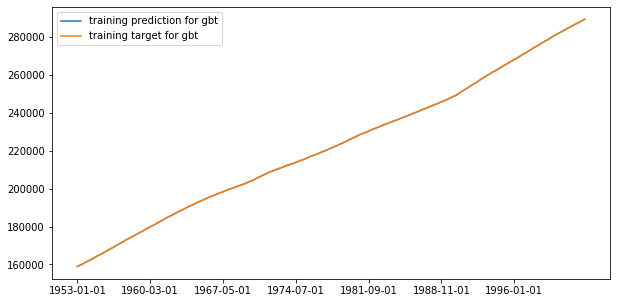

In [0]:
prediction_train_gbt = predictions_train_gbt.select('predicted_value_gbt').toPandas()['predicted_value_gbt'].astype(float)
target_train_gbt = predictions_train_gbt.select('value').toPandas()['value'].astype(float)
date_train_gbt = predictions_train_gbt.select('date').toPandas()['date']

plt.figure(figsize = (10,5))
plt.plot(date_train_gbt, prediction_train_gbt, label='training prediction for gbt')
plt.plot(date_train_gbt, target_train_gbt, label='training target for gbt')
x_ticks = date_train_gbt.index 
plt.xticks(x_ticks)
plt.locator_params(axis = 'x', nbins = 7)
plt.legend()
plt.show()

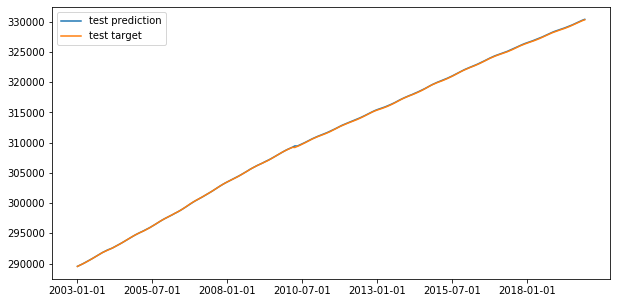

In [0]:
prediction_test_gbt = predictions_test_gbt.select('predicted_value_gbt').toPandas()['predicted_value_gbt'].astype(float)
target_test_gbt = predictions_test_gbt.select('value').toPandas()['value'].astype(float)
date_test_gbt = predictions_test_gbt.select('date').toPandas()['date']

plt.figure(figsize = (10,5))
plt.plot(date_test_gbt, prediction_test_gbt, label='test prediction')
plt.plot(date_test_gbt, target_test_gbt, label='test target')
x_ticks = date_test_gbt.index 
plt.xticks(x_ticks)
plt.locator_params(axis = 'x', nbins = 7)
plt.legend()
plt.show()

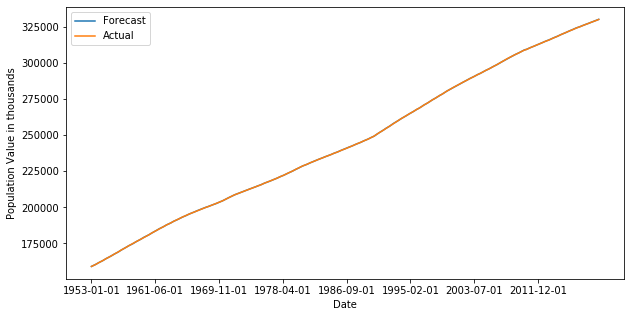

In [0]:
prediction_gbt = np.hstack((prediction_train_gbt, prediction_test_gbt))
target_gbt = np.hstack((target_train_gbt, target_test_gbt))
date_gbt = np.hstack((date_train_gbt, date_test_gbt))
plt.figure(figsize = (10,5))
plt.plot(date_gbt, prediction_gbt, label='Forecast')
plt.plot(date_gbt, target_gbt, label='Actual')
x_ticks = date_gbt 
plt.xticks(x_ticks)
plt.locator_params(axis = 'x', nbins = 8)
plt.xlabel("Date")
plt.ylabel("Population Value in thousands")
plt.legend()
plt.show()

In [0]:
def smape(A, F):
  return 100/len(A)*np.sum(2*np.abs(F-A)/(np.abs(A)+np.abs(F)))

In [0]:
error_train_gbt = smape(target_train_gbt, prediction_train_gbt)
error_train_gbt

Out[181]: 0.005051135924956597

In [0]:
error_test_gbt = smape(target_test_gbt, prediction_test_gbt)
error_test_gbt

Out[182]: 0.012306861781562801